<h1 style="text-align: center; font-weight: bold;">Narges Mohammadi Elyasi </h1>
<h1 style="text-align: center"> 810100258</h1>
<h1 style="text-align: center;">CA5 - Nural Network</h1>

## Setup environment

In [2]:
import ssl
import nltk
import re
import random
import gensim
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import string
from nltk.stem import WordNetLemmatizer
import gensim.downloader as api
import os
from sklearn.model_selection import train_test_split

ssl._create_default_https_context = ssl._create_unverified_context

## Config

### Model training config

In [3]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
SEQUENCE_LEN2 = 196
CNN_FILTERS = 64

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

### Load Data

In [5]:
FILE_ADDRESS = 'twitter-suicidal-data.csv'

In [6]:
dataframe = pd.read_csv(FILE_ADDRESS)

In [7]:
dataframe.head()

,tweet,intention
0,my life is meaningless i just want to end my l...,1
1,muttering i wanna die to myself daily for a fe...,1
2,work slave i really feel like my only purpose ...,1
3,i did something on the 2 of october i overdose...,1
4,i feel like no one cares i just want to die ma...,1


## Data Preprocessing

In [8]:
nltk.download(["words","stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Narges\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Narges\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Narges\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Narges\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Narges\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
def convert_emoji_to_text(text):
    emojiless_text = re.sub(r'[^\w\s]', ' ', text)
    return emojiless_text

lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
valid_words = set(words.words())

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    lowered_text = text.lower()
    nonnumeric_text = ''.join(char for char in lowered_text if char not in string.punctuation and not char.isdigit())
    linkremoved_text = re.sub(r'http[s]?://\S+|www\.\S+|[^\w\s]', '', nonnumeric_text)
    userless_text = re.sub(r'@\w+', '', linkremoved_text)
    emojiless_text = convert_emoji_to_text(userless_text)
    spaceless_text = re.sub(r'\s+', ' ', emojiless_text).strip()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in spaceless_text.split()]
    filtered_tokens = [word for word in lemmatized_tokens if word not in stop_words]
    valid_tokens = [word for word in filtered_tokens if word in valid_words]
    return valid_tokens


## Phase 0 Questions:
### 1. Why do we convert the works to lowercase?
Converting words to lowercase in word preprocessing is a common practice in natural language processing (NLP) for several reasons:

Normalization: By converting all words to lowercase, we ensure that words are consistent and standardized throughout the text. This helps in reducing the vocabulary size by merging words that differ only in their casing (e.g., "Hello" and "hello" are treated as the same word).

Tokenization: Lowercasing words makes it easier to tokenize the text into individual words. Tokenization is a fundamental preprocessing step in NLP where text is split into smaller units (words, phrases, or symbols) to analyze and process them.

Consistency in Text Analysis: Lowercasing words ensures that text analysis methods such as counting word frequencies or identifying common words are not affected by the casing variations of the words.

Improved Model Performance: A model that is case-insensitive can benefit from lowercasing words as it reduces the complexity of the input data and improves generalization by treating words with different cases as the same word.

Avoiding Duplication: Lowercasing words helps in avoiding duplication of words in the vocabulary for words that differ only in casing. This helps in reducing the model's training time and memory usage.

Overall, converting words to lowercase in word preprocessing is a standard practice that facilitates text processing, improves model performance, and ensures consistency in NLP tasks.

### 2. Why do we omit the numeric data? Tell the pros and cons of this method
Omitting numeric data in some natural language processing (NLP) tasks is a common approach because the presence of numeric data may introduce noise or unnecessary complexity to the textual analysis. Here are some pros and cons of omitting numeric data in NLP tasks:

Pros of Omitting Numeric Data:

Improved Text Processing: Omitting numeric data simplifies text processing and analysis by focusing on textual content only. This can lead to more efficient text preprocessing steps such as tokenization, stemming, and vectorization.
Reduced Noise: Numeric data can sometimes be noisy and irrelevant to certain NLP tasks. By removing numeric values, you may improve the accuracy and reliability of the analysis focused on the textual content.
Enhanced Model Performance: In some NLP tasks like sentiment analysis or text classification, including numeric data alongside text may complicate the model training process. Omitting numeric data can lead to more streamlined and optimized models.
Cons of Omitting Numeric Data:

Information Loss: Numeric data may contain valuable information that can be relevant for the NLP task at hand. Omitting numeric data may result in the loss of important context or details that could enhance the understanding of the text.
Contextual Relevance: In some cases, numeric data within text can provide context or additional meaning to the textual content. Omitting numeric data completely may overlook this context and potentially impact the performance of certain NLP tasks.
Overgeneralization: Omitting numeric data from the analysis may lead to oversimplification of the data, potentially ignoring important patterns or variations that exist within the text along with the numeric information.
Ultimately, the decision to omit numeric data in NLP tasks depends on the specific requirements, objectives, and characteristics of the dataset and the task at hand. It is important to carefully consider the pros and cons and determine whether keeping or omitting numeric data aligns with the goals of the NLP analysis.

### 3. Why haven't we removed the hashtags?

I think that hashtags in social media often point to a keyword of an important thing or feature that is related to our text. That is why they could be od use to us. They can be used to categorize the content of a text in social media, create connections between posts, and express emotions or opinions. While hashtags can provide valuable information and context for understanding the content of social media data, it is important to consider their impact on NLP models. Here are some reasons why we often do not remove hashtags in social media data and the potential impact they can have on our models:

Context and Meaning: Hashtags can provide additional context and meaning to the text by highlighting key topics, events, or sentiments discussed in the social media posts. Removing hashtags may result in the loss of valuable information that could help improve the model's understanding of the data.

Trend Analysis: Hashtags are commonly used to track trends and topics that are popular or relevant on social media at a given time. Analyzing hashtags alongside text data can help in identifying trending topics, analyzing user sentiment, and understanding the overall social media landscape.

Sentiment Analysis: Hashtags are often used to express emotions or opinions related to a specific topic. Including hashtags in sentiment analysis tasks can help capture the sentiment associated with the topic or theme referenced by the hashtags.

User Engagement: Hashtags play a significant role in social media engagement and can influence the reach and visibility of posts. Analyzing hashtags along with the text data can provide insights into user engagement, participation in discussions, and overall social media interactions.

Feature Engineering: Hashtags can be used as features or input signals in NLP models to improve performance in certain tasks. Extracting and incorporating hashtags as additional features can enhance the model's ability to capture specific topics or themes present in the data.

In [10]:
text_column_name = 'tweet'
selected_indices = random.sample(range(len(dataframe)), 5)
selected_rows = dataframe.loc[selected_indices]
print(selected_rows[text_column_name])

6379    after a fitfull night of tossing and turning o...
163     i ve tried everything else i just can not go o...
6032    has tonsillitis or glandular fever either way ...
751     the idea of death seems so peaceful i want to ...
6922     i just saw an old clip of you on idol and it ...
Name: tweet, dtype: object


In [11]:
sample_df= deepcopy(dataframe)
sample_df['tokens'] = sample_df[text_column_name].apply(preprocess_data)
sample_df['token_count'] = sample_df['tweet'].apply(lambda x: len(preprocess_data(x)))


In [12]:
print(sample_df['tokens'].loc[selected_indices])

6379                    [night, tossing, turning, er, go]
163     [tried, everything, else, go, another, day, de...
6032    [ha, tonsillitis, glandular, fever, either, wa...
751             [idea, death, peaceful, want, cant, want]
6922                   [saw, old, clip, idol, made, miss]
Name: tokens, dtype: object


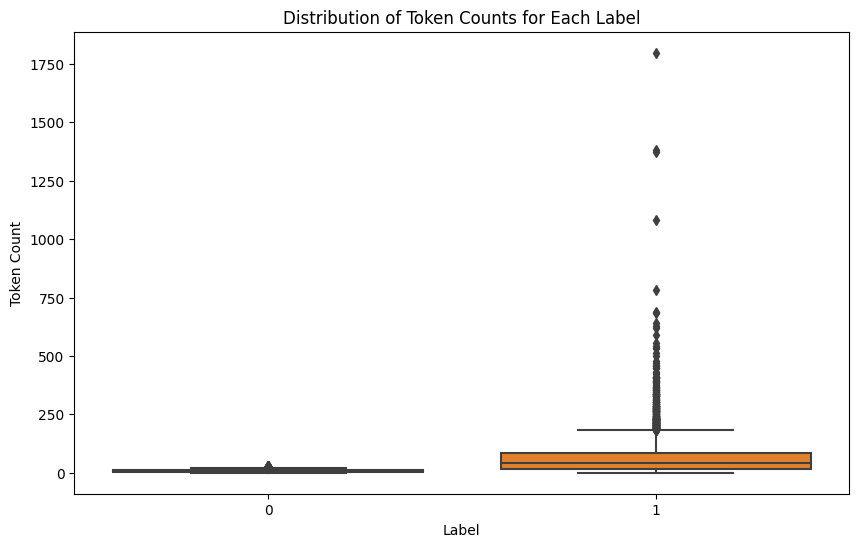

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='intention', y='token_count', data=sample_df)
plt.title('Distribution of Token Counts for Each Label')
plt.xlabel('Label')
plt.ylabel('Token Count')
plt.show()

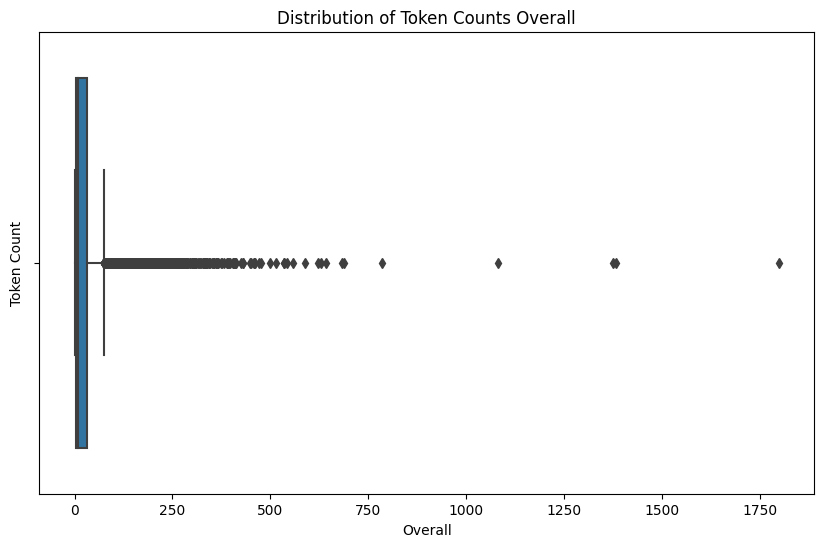

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=sample_df['token_count'])
plt.title('Distribution of Token Counts Overall')
plt.xlabel('Overall')
plt.ylabel('Token Count')
plt.show()

In [15]:
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


### Word2Vec - Word Embedding

In [16]:
W2V_PATH = 'word2vec'
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [17]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size

### Dataset

In [18]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe.copy()
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")
        self.dataframe.loc[:, self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
        self.dataframe.loc[:, "vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
    def _get_word_vectors(self, tokens: list) -> torch.tensor:
        vector_list = []
        for token in tokens:
            if isinstance(token, str) and token in self.w2v_model:
                vector_list.append(self.w2v_model[token])
            else:
                vector_list.append(np.zeros(self.vector_size))
        return torch.tensor(vector_list, dtype=torch.float32)

    def _pad(self, tokens: list) -> list:
        num_padding = max(0, self.max_sequence_len - len(tokens))
        if len(tokens) > self.max_sequence_len:
            padded_tokens = tokens[:self.max_sequence_len]
        else:
            padding = ['0'] * num_padding
            padded_tokens =  tokens + padding
        return padded_tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    def train_test_split(self, test_size=0.2, random_state=None):
        X = self.dataframe.drop('intention', axis=1)
        y = self.dataframe['intention']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test

    def split_datasets(self, test_size=0.2, random_state=None):
        train_df, test_df = train_test_split(self.dataframe, test_size=test_size, random_state=random_state)
        return Twitter(train_df, self.w2v_model, self.max_sequence_len), Twitter(test_df, self.w2v_model, self.max_sequence_len)
    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

### What are the ways to handle words that are not in the dictionary?
When dealing with words that are not present in the word2vec dictionary, there are several strategies you can employ:

Zero Vector: Use a zero vector for out-of-vocabulary (OOV) words. This is simple but may not be the most effective as it doesn't provide any meaningful information.

Random Vector: Initialize OOV words with random vectors. The randomness introduces some variety, although the vectors may not be meaningful.

Average Vector: Use the average vector of all word vectors in the dictionary. This provides a central point in the vector space but may not be representative of the OOV word's semantics.

Subword Information: Utilize models like FastText that generate vectors for OOV words based on subword information, which can capture the meaning of words by their parts (prefixes, suffixes, etc.).

Custom Embeddings: Train custom embeddings for your specific dataset, which can include the OOV words encountered in your corpus.

Placeholder Vector: Assign a unique placeholder vector for all OOV words. This can be useful if you want to treat all OOV words uniformly.

Similarity-based Vector: Find the most similar words that are in the dictionary and use their vectors or an average of their vectors for the OOV word.

Contextual Embeddings: Use contextual embedding models like BERT or ELMo that generate word vectors based on the context in which the word appears, thus providing vectors for OOV words based on their usage.

Each method has its pros and cons, and the choice may depend on the specific application and the nature of the dataset you're working with. It's also possible to combine these strategies to handle OOV words more effectively.

## Prepare Data

### Split Data into train-valid

In [19]:
twitter_dataset = Twitter(dataframe, w2v_model, SEQUENCE_LEN)
twitter_dataset.seq_report()

Deleted 0-Len Samples: 85


C:\Users\Narges\AppData\Local\Temp\ipykernel_9976\15560500.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  return torch.tensor(vector_list, dtype=torch.float32)


Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[ 8300 
:::::All Valid Tokens:::[ 8231 
:::::Valid Tokens:::[99.17%]


In [20]:
X_train, X_test, y_train, y_test = twitter_dataset.train_test_split(test_size=0.2, random_state=42)

### Create Datasets

In [21]:
train_dataset, test_dataset = twitter_dataset.split_datasets(test_size=0.2, random_state=42)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Deleted 0-Len Samples: 0
Deleted 0-Len Samples: 0
Training dataset size: 7227
Testing dataset size: 1807


### Model and Train

### Utils

In [22]:
@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    total_samples = 0
    correct_predictions = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) ##its here
        loss = loss_function(outputs, labels)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(correct_predictions / total_samples, 5),
        )

    test_loss /= total_samples
    test_acc = correct_predictions / total_samples
    return test_loss, test_acc


In [23]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str = 'auto',
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        correct_predictions = 0
        total_samples = 0

        itr = tqdm(train_loader, total=len(train_loader), leave=False)##it wasnt here

        for idx, (inputs, labels) in enumerate(itr, start=1):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            loss = loss_function(outputs, labels)
            epoch_loss += loss.item() * inputs.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
            itr.set_postfix(
              loss=round(loss.item(), 5),
              accuracy=round(correct_predictions / total_samples, 5),
              )

        epoch_loss /= total_samples
        epoch_acc = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        print(f"Epoch [{epoch+1}/{epochs}]: "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [24]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [25]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    all_labels = []
    all_predictions = []

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    labels = all_labels
    predicted = all_predictions

    cm = metrics.confusion_matrix(y_true=labels, y_pred=predicted)

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f")
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)
    plt.show()

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

### Why does kernel size matter in CNN?

Kernel size in Convolutional Neural Networks (CNNs) plays a crucial role in determining the effectiveness and efficiency of the network in learning features from the input data.

Receptive field: The size of the kernel determines the area of the input image that each convolutional operation will focus on. A larger kernel size leads to a larger receptive field, allowing the network to capture more spatial information and learn complex patterns in the input data.

Feature extraction: Smaller kernel sizes are effective in capturing fine details and local patterns in the input data, while larger kernel sizes are better at capturing global features and overall structure of the input. By using a combination of different kernel sizes in CNNs, the network can effectively learn features at various levels of abstraction.

Computational efficiency: Smaller kernel sizes require fewer parameters and computations, making the network more efficient and easier to train. However, larger kernel sizes may be necessary in certain cases to capture more complex features and patterns in the data.

Overfitting: Using overly large kernel sizes in a CNN can lead to overfitting, as the network may memorize the training data instead of generalizing well to unseen data. It is important to carefully select the appropriate kernel size based on the complexity of the input data and the specific task at hand.

Overall, the choice of kernel size in a CNN should be carefully considered based on the specific requirements of the task and the characteristics of the input data to ensure optimal performance of the network.

In [26]:
class CNN(nn.Module):
  def __init__(self, kernel_size1, kernel_size2, linear_input_size):
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(300, 64, kernel_size=kernel_size1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=kernel_size2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=linear_input_size),
            nn.Flatten(),
            nn.Linear(3840, 128),
            nn.Linear(128, 2)
        )

  def forward(self, x):
        x = x.permute(0, 2, 1)
        return self.model(x)


### Training

In [27]:
torch.manual_seed(42)
model_p2 = CNN(kernel_size1=3, kernel_size2=3,linear_input_size =2)

In [28]:
cnn_model_train_history = train_model(
    model=model_p2,
    batch_size=BATCH_SIZE,
    loss_function=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model_p2.parameters(), lr=LEARNING_RATE),
    epochs=EPOCHS,
    train_set=train_dataset,
    valid_set=test_dataset,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch [1/15]: Train Loss: 0.3710, Train Acc: 0.8358, Valid Loss: 0.2964, Valid Acc: 0.8904


Epoch [2/15]: Train Loss: 0.2830, Train Acc: 0.8864, Valid Loss: 0.2327, Valid Acc: 0.9070


Epoch [3/15]: Train Loss: 0.2327, Train Acc: 0.9038, Valid Loss: 0.2266, Valid Acc: 0.9037


Epoch [4/15]: Train Loss: 0.1873, Train Acc: 0.9225, Valid Loss: 0.2123, Valid Acc: 0.9148


Epoch [5/15]: Train Loss: 0.1590, Train Acc: 0.9369, Valid Loss: 0.2249, Valid Acc: 0.9120


Epoch [6/15]: Train Loss: 0.1326, Train Acc: 0.9498, Valid Loss: 0.2814, Valid Acc: 0.9054


Epoch [7/15]: Train Loss: 0.0938, Train Acc: 0.9676, Valid Loss: 0.2521, Valid Acc: 0.9081


Epoch [8/15]: Train Loss: 0.0658, Train Acc: 0.9776, Valid Loss: 0.2935, Valid Acc: 0.9070


Epoch [9/15]: Train Loss: 0.0507, Train Acc: 0.9833, Valid Loss: 0.3324, Valid Acc: 0.9037


Epoch [10/15]: Train Loss: 0.0321, Train Acc: 0.9892, Valid Loss: 0.4146, Valid Acc: 0.9043


Epoch [11/15]: Train Loss: 0.0233, Train Acc: 0.9932, Valid Loss: 0.4235, Valid Acc: 0.9020


Epoch [12/15]: Train Loss: 0.0207, Train Acc: 0.9932, Valid Loss: 0.4585, Valid Acc: 0.9020


Epoch [13/15]: Train Loss: 0.0207, Train Acc: 0.9923, Valid Loss: 0.4778, Valid Acc: 0.9004


Epoch [14/15]: Train Loss: 0.0146, Train Acc: 0.9952, Valid Loss: 0.5051, Valid Acc: 0.8998


Epoch [15/15]: Train Loss: 0.0145, Train Acc: 0.9947, Valid Loss: 0.5297, Valid Acc: 0.8987


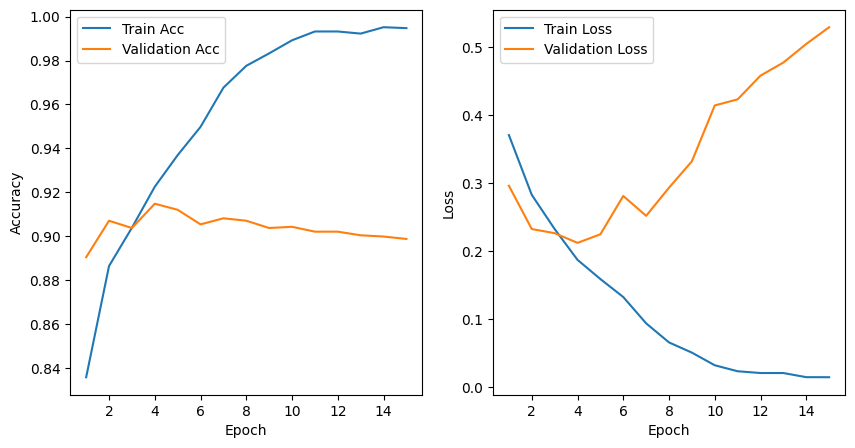

In [29]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

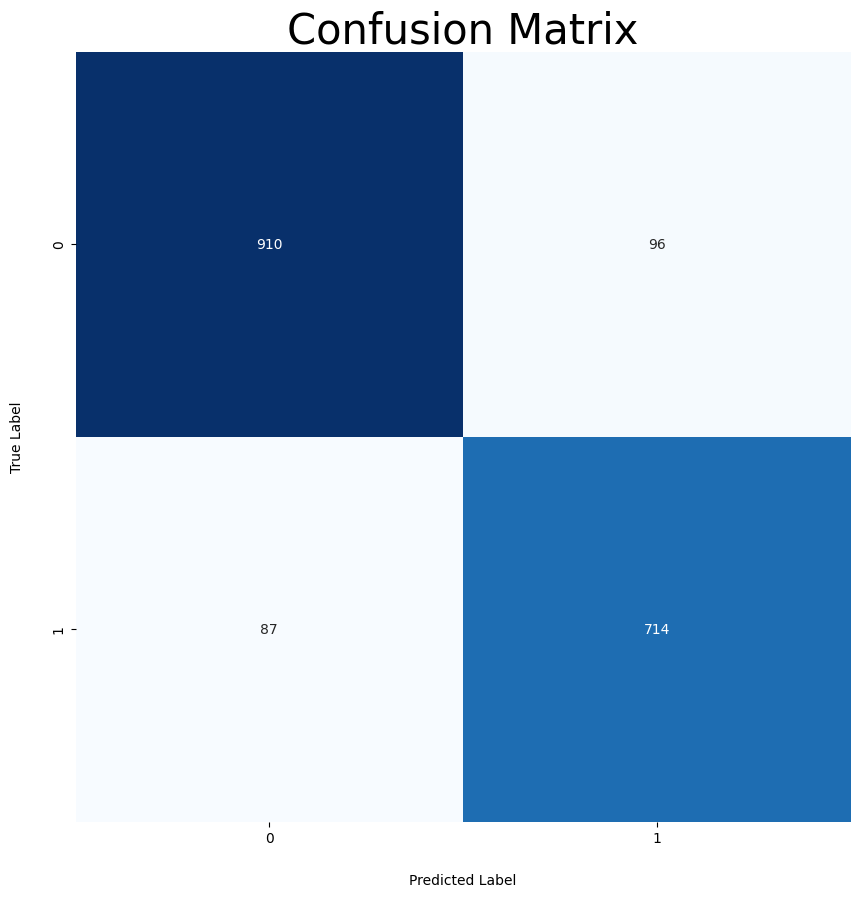

In [30]:
cnn_model_report = generate_confusion_matrix(
    model=model_p2,
    dataset=test_dataset,
)

In [31]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.898
F1:        0.898
Precision: 0.897
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1006
           1       0.88      0.89      0.89       801

    accuracy                           0.90      1807
   macro avg       0.90      0.90      0.90      1807
weighted avg       0.90      0.90      0.90      1807



### Phase 3: Change Kernel Size to 196

In [32]:
twitter_dataset = Twitter(dataframe, w2v_model, SEQUENCE_LEN2)

train_dataset2, test_dataset2 = twitter_dataset.split_datasets(test_size=0.2, random_state=42)

print(f"Training dataset size: {len(train_dataset2)}")
print(f"Testing dataset size: {len(test_dataset2)}")

Deleted 0-Len Samples: 85
Deleted 0-Len Samples: 0
Deleted 0-Len Samples: 0
Training dataset size: 7227
Testing dataset size: 1807


In [33]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(300, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(12288, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        return self.model(x)

In [34]:
torch.manual_seed(42)
cnn_model_2 = CNN2()

In [35]:
import torch.optim as optim
cnn_model_train_history_2 = train_model(
    model = cnn_model_2,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(cnn_model_2.parameters(), lr = LEARNING_RATE),
    epochs = EPOCHS,
    train_set = train_dataset2,
    valid_set = test_dataset2,
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch [1/15]: Train Loss: 0.4895, Train Acc: 0.8258, Valid Loss: 0.4399, Valid Acc: 0.8716


Epoch [2/15]: Train Loss: 0.4462, Train Acc: 0.8650, Valid Loss: 0.4238, Valid Acc: 0.8888


Epoch [3/15]: Train Loss: 0.4351, Train Acc: 0.8767, Valid Loss: 0.4182, Valid Acc: 0.8949


Epoch [4/15]: Train Loss: 0.4256, Train Acc: 0.8858, Valid Loss: 0.4124, Valid Acc: 0.9009


Epoch [5/15]: Train Loss: 0.4213, Train Acc: 0.8897, Valid Loss: 0.4185, Valid Acc: 0.8921


Epoch [6/15]: Train Loss: 0.4119, Train Acc: 0.8995, Valid Loss: 0.4103, Valid Acc: 0.8993


Epoch [7/15]: Train Loss: 0.4098, Train Acc: 0.9016, Valid Loss: 0.4091, Valid Acc: 0.9026


Epoch [8/15]: Train Loss: 0.4040, Train Acc: 0.9080, Valid Loss: 0.4147, Valid Acc: 0.8937


Epoch [9/15]: Train Loss: 0.3989, Train Acc: 0.9139, Valid Loss: 0.4176, Valid Acc: 0.8904


Epoch [10/15]: Train Loss: 0.3965, Train Acc: 0.9155, Valid Loss: 0.4213, Valid Acc: 0.8866


Epoch [11/15]: Train Loss: 0.3931, Train Acc: 0.9193, Valid Loss: 0.4163, Valid Acc: 0.8926


Epoch [12/15]: Train Loss: 0.3892, Train Acc: 0.9238, Valid Loss: 0.4071, Valid Acc: 0.9020


Epoch [13/15]: Train Loss: 0.3875, Train Acc: 0.9254, Valid Loss: 0.4108, Valid Acc: 0.9009


Epoch [14/15]: Train Loss: 0.3865, Train Acc: 0.9251, Valid Loss: 0.4303, Valid Acc: 0.8794


Epoch [15/15]: Train Loss: 0.3835, Train Acc: 0.9292, Valid Loss: 0.4029, Valid Acc: 0.9076


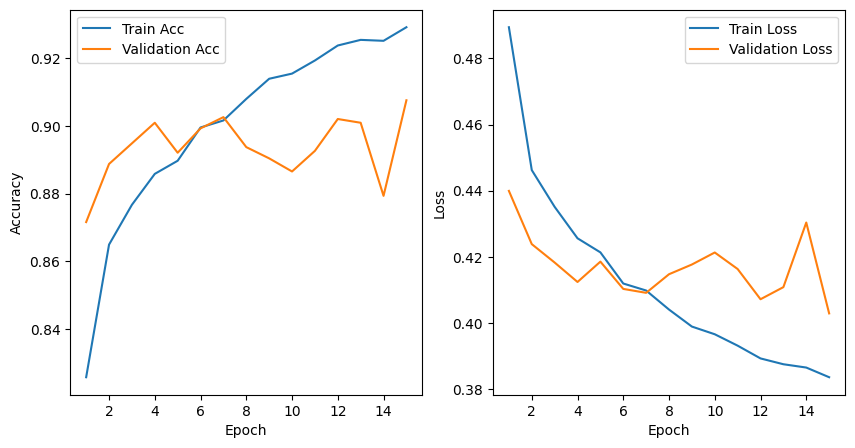

In [36]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_2["train_acc"]),
            ("Validation Acc", cnn_model_train_history_2["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_2["train_loss"]),
            ("Validation Loss", cnn_model_train_history_2["valid_loss"])
        ]
    }
)

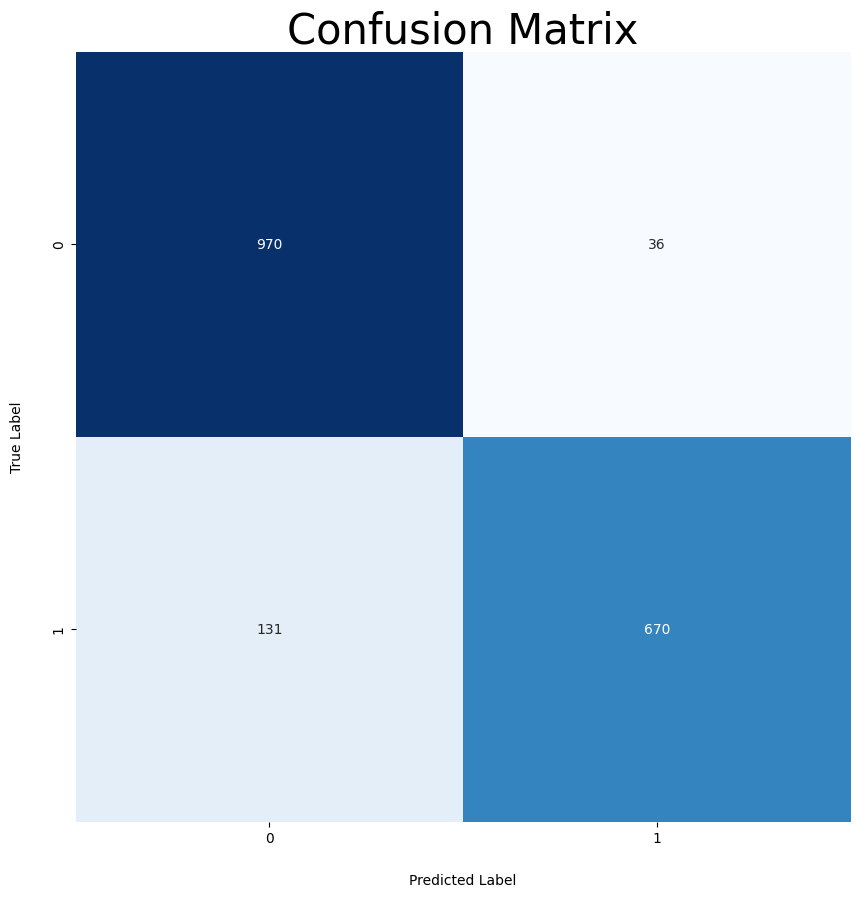

In [37]:
cnn_model_report_2 = generate_confusion_matrix(
    model = cnn_model_2,
    dataset = test_dataset2,
)

In [38]:
print(f"Recall:    {cnn_model_report_2['recall']:.3f}")
print(f"F1:        {cnn_model_report_2['f1']:.3f}")
print(f"Precision: {cnn_model_report_2['precision']:.3f}")
print(cnn_model_report_2['report'])

Recall:    0.900
F1:        0.905
Precision: 0.915
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1006
           1       0.95      0.84      0.89       801

    accuracy                           0.91      1807
   macro avg       0.92      0.90      0.90      1807
weighted avg       0.91      0.91      0.91      1807



### Phase 4: Dropout and Normalization

In [39]:
twitter_dataset = Twitter(dataframe, w2v_model, SEQUENCE_LEN2)

train_dataset3, test_dataset3 = twitter_dataset.split_datasets(test_size=0.2, random_state=42)

print(f"Training dataset size: {len(train_dataset2)}")
print(f"Testing dataset size: {len(test_dataset2)}")

Deleted 0-Len Samples: 85
Deleted 0-Len Samples: 0
Deleted 0-Len Samples: 0
Training dataset size: 7227
Testing dataset size: 1807


In [40]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(300, 64, kernel_size=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(12288, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, 2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        return self.model(x)

In [41]:
torch.manual_seed(42)
cnn_model_3 = CNN3()

In [42]:
import torch.optim as optim
cnn_model_train_history_3 = train_model(
    model=cnn_model_3,
    batch_size=BATCH_SIZE,
    loss_function=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(cnn_model_3.parameters(), lr=LEARNING_RATE),
    epochs=EPOCHS,
    train_set=train_dataset3,
    valid_set=test_dataset3,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

Epoch [1/15]: Train Loss: 0.4734, Train Acc: 0.8583, Valid Loss: 0.4230, Valid Acc: 0.9004


Epoch [2/15]: Train Loss: 0.4150, Train Acc: 0.9066, Valid Loss: 0.4087, Valid Acc: 0.9098


Epoch [3/15]: Train Loss: 0.3885, Train Acc: 0.9286, Valid Loss: 0.4160, Valid Acc: 0.8937


Epoch [4/15]: Train Loss: 0.3731, Train Acc: 0.9433, Valid Loss: 0.4008, Valid Acc: 0.9103


Epoch [5/15]: Train Loss: 0.3603, Train Acc: 0.9566, Valid Loss: 0.4179, Valid Acc: 0.8926


Epoch [6/15]: Train Loss: 0.3509, Train Acc: 0.9657, Valid Loss: 0.4188, Valid Acc: 0.8943


Epoch [7/15]: Train Loss: 0.3450, Train Acc: 0.9703, Valid Loss: 0.4087, Valid Acc: 0.9009


Epoch [8/15]: Train Loss: 0.3399, Train Acc: 0.9754, Valid Loss: 0.4202, Valid Acc: 0.8888


Epoch [9/15]: Train Loss: 0.3380, Train Acc: 0.9766, Valid Loss: 0.4153, Valid Acc: 0.8926


Epoch [10/15]: Train Loss: 0.3347, Train Acc: 0.9802, Valid Loss: 0.4141, Valid Acc: 0.8987


Epoch [11/15]: Train Loss: 0.3332, Train Acc: 0.9815, Valid Loss: 0.4071, Valid Acc: 0.9026


Epoch [12/15]: Train Loss: 0.3299, Train Acc: 0.9846, Valid Loss: 0.4119, Valid Acc: 0.8965


Epoch [13/15]: Train Loss: 0.3311, Train Acc: 0.9834, Valid Loss: 0.4152, Valid Acc: 0.8943


Epoch [14/15]: Train Loss: 0.3297, Train Acc: 0.9853, Valid Loss: 0.4417, Valid Acc: 0.8694


Epoch [15/15]: Train Loss: 0.3287, Train Acc: 0.9856, Valid Loss: 0.4104, Valid Acc: 0.9004


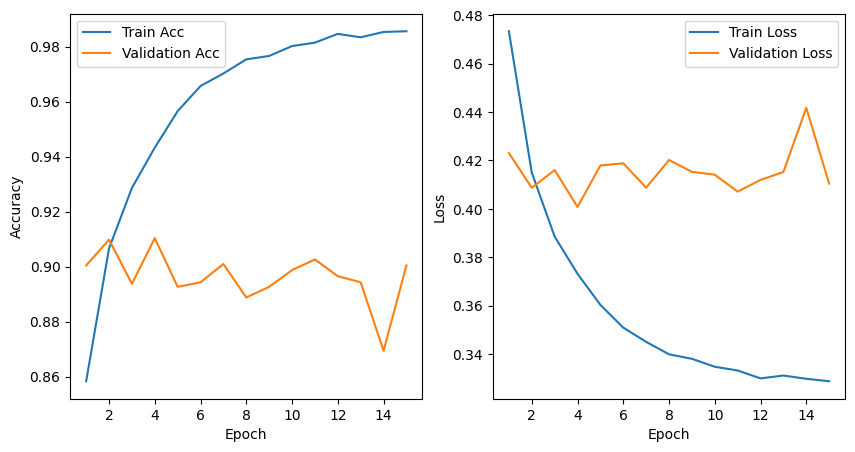

In [43]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_3["train_acc"]),
            ("Validation Acc", cnn_model_train_history_3["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_3["train_loss"]),
            ("Validation Loss", cnn_model_train_history_3["valid_loss"])
        ]
    }
)

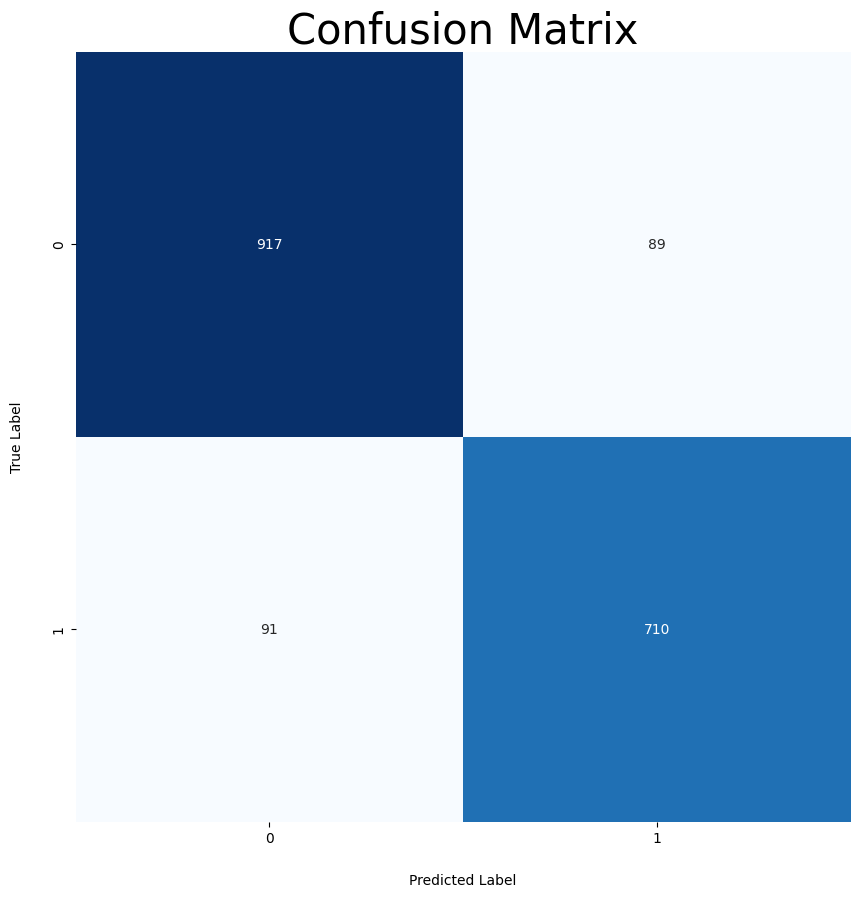

In [44]:
cnn_model_report_3 = generate_confusion_matrix(
    model = cnn_model_3,
    dataset = test_dataset3,
)

In [45]:
print(f"Recall:    {cnn_model_report_3['recall']:.3f}")
print(f"F1:        {cnn_model_report_3['f1']:.3f}")
print(f"Precision: {cnn_model_report_3['precision']:.3f}")
print(cnn_model_report_3['report'])

Recall:    0.899
F1:        0.899
Precision: 0.899
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1006
           1       0.89      0.89      0.89       801

    accuracy                           0.90      1807
   macro avg       0.90      0.90      0.90      1807
weighted avg       0.90      0.90      0.90      1807



##Overall Comparison:
The loss function in part 1 with sequence length being 64 is quite low and throughout all the epochs, it was dicreased and almost approximated to 0. The loss function in part 2 with sequence length being 196 and in part 3, was generally more in scale. But the accuracies in these 3 parts do not vary that much, though if we want to compare, the f1 score in part 3 is lower than the other 2. The other significant aspect of the 3rd part was the way that the model performed on the test set. It was not overall bad, but the performance on the test set had significant ups and downs, as you can see in the plots.

In the 2nd part, the test accuracy and the train accuracy converge closer to each other, in comparison to the first part.